# Predicting Opening Box Office Weekend #

## Introduction

**We** investigate whether tweets the amount and sentiment in them can predict opening weekend of box office. Specifically we target a threshold i.e. around 30 million dollars, but more specifically it is the mean of the opening weekend of the entire dataset. We can target higher levels as well.


## About the Dataset

**Labeled data for classifying tweets** 

This dataset was obtained from multiple sources and contains manually labeled dataset.

* [Sanders Dataset](http://www.sananalytics.com/lab/twitter-sentiment/)
* NLTK Tweet Corpora
* Custom Manually Labeled Dataset (Around 400 tweets)

**Twitter Data for realtime gathering of Historic Data.**

A custom java **_web scraper_** and **_REST_** service exposing the twitter API was written for searching historic data on twitter. This was done because twitter does not provide access to historic data past 7 days, whereas for our analysis we needed historic data going back years.

**Movie Dataset**

A custom java module was written for integration with the rest API exposed by the movie DB [The Movie DB API](https://www.themoviedb.org/documentation/api). This API is used to create a movie dataset csv file. This is an interactive command line application that can be used to gather the data about movie which includes revenue, votes, budget, title, release date etc. In this dataset we manually appended a column containing the opening weekend revenue obtained from BOXOfficeMojo API.



## Steps ##

Brief overview of the steps involved is mentioned below (detailed explanation will follow): 

1. We gather the data about the movies released in a year using the java command line application **movieDB.jar**. We can specify the number of records to retrieve and other criterion such as average vote, rating threshold, number of votes, release year. We can also save the file by specifying the location of the file.   
2. We **preprocess** the tweets and train our classifier _[SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)_ with the labeled dataset as mentioned above.  
3. Using the dataset in step 1, We now use our custom java **_REST_** web service's search interface to search for tweets pertaining to the movie. We search for tweets on a weekly basis for **4 weeks** prior to the film's release. We then either directly store them or classify them into positive and negative sentiment and then store them. This is done so that in future retrieval is fast. 
4. We now classify the tweet or if classification was done earlier, we just read the file containing classification metrics.
5. Now, we explore whether tweets have predictive power or not. We add certain features to the above metrics and then train LogisticRegression classifier to predict whether the movie will earn above a certain threshold on its opening weekend or not. 




## Frameworks or languages used
* Java
* Scikit-Learn, NLTK, Pandas
* Retrofit for REST integration
* Java Rest Web Services

In [293]:
import pandas as pd
import numpy as np
import nltk 
import collections
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from __future__ import with_statement
from contextlib import closing
from nltk.tokenize import TweetTokenizer
from nltk.corpus import twitter_samples 
from nltk.corpus import movie_reviews, stopwords
from nltk.probability import FreqDist, ConditionalFreqDist
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.kernel_approximation import RBFSampler
from sklearn.svm import SVC
import datetime
from datetime import date,timedelta
import re
from sklearn.pipeline import FeatureUnion
import matplotlib.pylab as plt
from nltk.corpus import movie_reviews, stopwords
from nltk.metrics import BigramAssocMeasures
from nltk.probability import FreqDist, ConditionalFreqDist
from sklearn_pandas import DataFrameMapper
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8


In [3]:
def plotROCGraph(accuracy,fpr_tr, tpr_tr, thresholds_tr,model_label):
    plt.plot(fpr_tr,tpr_tr,label=' '+model_label+ " (AUC="+accuracy+ " )")
    plt.xlabel("False positive rate (fpr)")
    plt.ylabel("True positive rate (tpr)")
    plt.plot([0,1],[0,1],"m--",label="Random Sampling (AUC=.50)")
    plt.legend(loc=3)
    plt.show()
    
def getNltkTweets(filename):
    temp=twitter_samples.abspath(filename)
    with open(temp, 'rb') as f:
        data = f.readlines()
    data = map(lambda x: x.rstrip(), data)
    data_json_str = "[" + ','.join(data) + "]"
    data_df = pd.read_json(data_json_str)
    return data_df

def transformNltkTweets(df,sentiment):
    df2 = pd.DataFrame(data=None, columns=frame.columns)
    df2['Topic']=''
    df2['Sentiment']=sentiment
    df2['TweetId']=df['id']
    df2['TweetText']=df['text']
    return df

* Just read the tweet corpus full_corpus.csv, movieDB dataset (ds_movie_corpus) containing the movies released in year 2013 and 2014.
* Process the movie titles (remove the invalid characters for filenames). Movie titles are used as file names later.
* Just select those movies which release on more than 2000 theatres. 

In [212]:
dirLocation='movieTweetStorage'
frame=pd.read_csv('full-corpus.csv',delimiter=',')
#Append NLTK tweets
dfPos=getNltkTweets('positive_tweets.json')
dfNeg=getNltkTweets('negative_tweets.json')
frame.append(transformNltkTweets(dfPos,'positive'))
frame.append(transformNltkTweets(dfNeg,'negative'))
movieCorpus=pd.read_csv('ds_movie_corpus.csv',delimiter=',')
movieCorpus=movieCorpus[movieCorpus['revenue']!=0]
movieCorpus['title']=movieCorpus['title'].apply(lambda x:  re.sub('[^-a-zA-Z0-9_.() ]+', '', x))
#let's pick only movies that open on more than 2000 theatres so that opening_weekend prediction is relevant otherwise 
#the movie that is released on fewer theatres will not match the opening weekend revenue of other movie. 
movieCorpus=movieCorpus[movieCorpus['Theatres']>2000]
movieCorpus.shape
positiveTweets=frame[frame['Sentiment']=='positive']
negativeTweets=frame[frame['Sentiment']=='negative']


The following cell contains a bunch of functions:

* `getWordList()`: for getting word lists from nltk corpus of tweets
* `getWordListFromTweer()`: Given a tweet it returns the tokenized words in the tweet.
* `searchTwitter()`: for invoking the REST search interface and searching twitter
* `storeTweets()`: for storing tweets as CSV file.
* `retrieveTweets()`: for retrieving tweets from the CSV file.
* `classifyTweetScikit()`: Uses the classifier created above to classify the tweet into positive or negative sentiment.
* `preprocessTweets()`: for removing hyperlinks, stop words and movie name from the tweet to prevent building of bias
* `best_word_features()`: This method selects only the best word features. `best` is determined by the high polarity negative or positive, computed using chi square metric.

In [5]:
import urllib2
import json
import ssl
import urllib

tknzr = TweetTokenizer(preserve_case=False,strip_handles=True, reduce_len=True)
def getWordList(data):
    word_list=[]
    for value in twitter_samples.strings(data):
        word_list=word_list+tknzr.tokenize(value)
    filtered_words=[word for word in word_list if word not in stopwords.words('english')]
    return filtered_words
def getWordListFromTweet(data):
    try:
        word_list=[]
        word_list=word_list+tknzr.tokenize(data)
        filtered_words=[word for word in word_list if word not in stopwords.words('english')]
    #     print filtered_words[:5]    
        return filtered_words
    except ValueError:
        print data

def searchTwitter(q,userName,to,since,until,lang,near,distance=0,maxResults=100):
    '''This function accepts a query to search twitter, As twitter does not provide historic data this function
    in turns invoke the twitter search service that I created. Key thing to note is twitter actually restricts 
    the requests sometimes, so this is not guaranteed to work'''
    parameterList={}
    parameterList['q']=q
    if(userName!=None):
        parameterList['u']=userName
        if(to):
            parameterList['to']="1"
        else:
            parameterList['to']="0"
    if(since!=None):
        parameterList['since']=since
    if(until!=None):
        parameterList['until']=until
    if(lang!=None):
        parameterList['lang']=lang
    if(maxResults!=100):
        parameterList['max']=maxResults
    if(near!=None):
        parameterList['near']=near
        if(distance!=0):
            parameterList['distance']=distance
        
    endPoint="http://localhost:8080/twitter/rest/search?"  
    encodedUrl=endPoint+urllib.urlencode(parameterList)
#     print encodedUrl
    response = urllib2.urlopen(encodedUrl)
    data = json.load(response)   
    return data


def storeTweets(data,movieName):
    '''This function stores the tweets in the directory. 
    Here movieName would include the movie_name+date_from+date_to'''
    df=pd.DataFrame(data)
    df.to_csv(dirLocation+'/'+movieName,sep=',', encoding='utf-8')
    return df
        
def retrieveTweets(movieName):
    '''Searches the directory location to search for tweets in the directory, 
    if it finds error it returns an empty data frame'''
    try:
        df=pd.read_csv(dirLocation+'/'+movieName,delimiter=',',encoding='utf-8')
        return df
    except IOError:
        return pd.DataFrame()

def classifyTweetScikit(data,classifier,movieName):
     '''Classifies the tweet given a classifier and data frame'''
     results=collections.defaultdict(int)
     for row in data['text']:
#             if  re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', row):
#                 continue
            cleanText=preprocessTweets(row,movieName)
            value=classifier.predict([cleanText])[0]
            print value
            results[value]=results[value]+1
     return results

def best_words_features():
    negids = movie_reviews.fileids('neg')
    posids = movie_reviews.fileids('pos')
    # poswords=getWordList(posids)
    # negwords=getWordList(negids)
    word_fd = FreqDist()
    label_word_fd = ConditionalFreqDist()

#     for word in movie_reviews.words(categories=['pos']):
#         word_fd[word.lower()]+=1
#         label_word_fd['pos'][word.lower()]+=1
       
    for text in positiveTweets['TweetText']:
        tweetWords=getWordListFromTweet(text)
        for word in tweetWords:
            word_fd[word.lower()]+=1
            label_word_fd['pos'][word.lower()]+=1
 
    
     
#     for word in  movie_reviews.words(categories=['neg']):
#         word_fd[word.lower()]+=1
#         label_word_fd['neg'][word.lower()]+=1
        
    for text in negativeTweets['TweetText']:
        tweetWords=getWordListFromTweet(text)
        for word in tweetWords:
            word_fd[word.lower()]+=1
            label_word_fd['neg'][word.lower()]+=1
    

    pos_word_count = label_word_fd['pos'].N()
    neg_word_count = label_word_fd['neg'].N()

    total_word_count = pos_word_count + neg_word_count

    word_scores = {}

    for word, freq in word_fd.iteritems():
        pos_score = BigramAssocMeasures.chi_sq(label_word_fd['pos'][word],
            (freq, pos_word_count), total_word_count)
        neg_score = BigramAssocMeasures.chi_sq(label_word_fd['neg'][word],
            (freq, neg_word_count), total_word_count)
        word_scores[word] = pos_score + neg_score
     

    best = sorted(word_scores.iteritems(), key=lambda (w,s): s, reverse=True)[:10000]
    bestwords = set([w for w, s in best])
    return bestwords

def preprocessTweets(data,movieName):
    '''Removes stopwords given a data frame containing tweet and moviename. It also removes the movie name 
    as movie name can cause bias in the classifier'''
    
    movieWords=nltk.word_tokenize(movieName)
    searchKeyWords=['trailer','see','watch','look','video']
    
    data=re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '',data)
    movieWords=[word.lower() for word in movieWords]
    words=getWordListFromTweet(data)
    words=[word for word in words if word.lower() not in movieWords]
    words=[word for word in words if word.lower() not in searchKeyWords]
    words=[word for word in words if word in bestwords]
   
    text=' '.join(words)
    return text




* The classifier chosen is **SGDClassifier** because of its efficiency and because you can switch and test various linear classifiers using different loss and penalty functions. 
* We then do a grid search using GridSearchCV of various parameter values for the estimators and transformers in the pipeline and train the classifier.
     
    

In [6]:
bestwords=best_words_features()
def buildTweetClassifier():
    relevantTweets=frame[(frame['Sentiment']=='positive') | (frame['Sentiment']=='negative')]
    X=np.array(relevantTweets.apply(lambda x: preprocessTweets(x[4],x[0]),axis=1))
    Y=relevantTweets['Sentiment']
    Y=pd.get_dummies(Y)
    Y=np.array(Y.positive)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)
    parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1,3)],
                   'tfidf__use_idf': (True, False),
                   'clf__alpha': (1e-2, 1e-3,1e-4,1e-5,1e-6,1)}
    #
    text_clf = Pipeline([('vect', CountVectorizer()),
                          ('tfidf', TfidfTransformer()),
                          ('clf', SGDClassifier(loss='hinge',penalty='l2',shuffle=True,
                                                 n_iter=5, random_state=42)),])
    gs_clf = GridSearchCV(text_clf,  parameters,cv=3)
    gs_clf.fit(X_train,Y_train)
    roc_accuracy=np.mean(cross_validation.cross_val_score(gs_clf,X,Y,scoring='roc_auc'))
    accuracy=np.mean(cross_validation.cross_val_score(gs_clf,X,Y,scoring='accuracy'))
    roc_accuracy=str(round(roc_accuracy,2))
#     Y_test_probability_gs_clf=gs_clf.predict_proba(X_test)[:,1]
#     fpr_gs_clfg, tpr_gs_clf, thresholds_gs_clf = metrics.roc_curve(Y_test, Y_test_probability_gs_clf)
#     plotROCGraph(roc_accuracy,fpr_gs_clfg,tpr_gs_clf,thresholds_gs_clf,'SGD Classifier')
    # text_clf.fit(X_train,Y_train)
    print gs_clf.best_params_
    print "Area under the ROC curve on the data ", roc_accuracy
    print "Accuracy of the classifier is ", accuracy
    return gs_clf

gs_clf=buildTweetClassifier()

{'vect__ngram_range': (1, 2), 'tfidf__use_idf': True, 'clf__alpha': 0.001}
Area under the ROC curve on the data  0.81
Accuracy of the classifier is  0.71266025641


This cell contains two functions:
* `getDates()`: to get the 4 week range prior to the movie's release date. 
* `getTweetsAndDoClassification()`: to search the tweets about movies and do classification. 

In [8]:
def getDates(releaseDate):
    dateList=[]
    release=datetime.datetime.strptime(releaseDate, "%d-%m-%Y").date()
#     "%d-%m-%Y"
#     "%Y-%m-%d"
    for i in range(5):
        dateValue=str(release)
        dateList.append(dateValue)
        release=(release-timedelta(days=7))
    return list(reversed(dateList))

def getTweetsAndDoClassification(query,movieName,dates,store=False,classifyTweet=True):
    ''' This method searches twitter with the given query. 
    In case of retrieve=True the query does not matter because this 
    method assumes that the results are already stored.'''

    resultDict=collections.defaultdict()
    resultDict['movieName']=movieName
    i=0
    for dateValue in dates:
        if(i==len(dates)-1):
            break;
        else:
            frame=retrieveTweets(movieName+'_'+dateValue+'_'+dates[i+1])
            if frame.empty:
                print 'searching ',query
                data=searchTwitter(query,None,False,dateValue,dates[i+1],'en',near=None,distance=15,maxResults=3000)
                if(data):
                    if(store):
                        frame=storeTweets(data,movieName+'_'+dateValue+'_'+dates[i+1])
                    else:
                        frame=pd.DataFrame(data)
            labelPos='pos'+'_'+'week_'+str(i) 
            labelNeg='neg'+'_'+'week_'+str(i)
            labelWeekTweetCount='week_tweet_count_'+str(i)
            resultDict[labelPos]=0
            resultDict[labelNeg]=0            
            if (classifyTweet):
                if len(frame.index)!=0 and not frame.empty:
    #                 outputText="For week starting in {date} The features are positive:{pos}, negatives:{neg}".format(date=dateValue,pos=results[1],neg=results[0])
    #                 print outputText
                    results=classifyTweetScikit(frame,gs_clf,movieName)
                    labelPos='pos'+'_'+'week_'+str(i) 
                    labelNeg='neg'+'_'+'week_'+str(i)
                    resultDict[labelPos]=results[1]
                    resultDict[labelNeg]=results[0]
            
            resultDict[labelWeekTweetCount]=len(frame.index)
                
                
        i=i+1
       
    return resultDict 



`doAnalysisAndStoreSentiments` : This method iterates the movie dataset and then iteratively invokes the functions in the above cell. 

In [362]:
def doAnalysisAndStoreSentiments(movieCorpus,name):
    listSentiments=[]
    i=0
    for row in movieCorpus.itertuples():
#         if i>4:
#             break;
#         i=i+1    
        movieTitle=row[5]
        movieReleaseDate=row[9]
        dates=getDates(movieReleaseDate)
        queryTitle=movieTitle
        if len(movieTitle)>25:
            queryTitle=queryTitle[:25]
        query=queryTitle+' trailer'
        result=getTweetsAndDoClassification(query,movieTitle,dates,store=True,classifyTweet=True)
        listSentiments.append(result)
    sentimentDF=pd.DataFrame(listSentiments)
    sentimentDF.to_csv(dirLocation+'/'+name,sep=',', encoding='utf-8')
    return sentimentDF

doAnalysisAndStoreSentiments(movieCorpus,'movie_sentiments')

* `prepareDataFrame()`: This method adds certain additional features to the above dataset and basically builds the dataset that will be used for doing classification of the opening_weekend based on this.
* `doOpeningWeekendClassificationAndStoreCSV()`: This method does the actual classification and plots the ROC graph if specified. This method uses LogisticRegression to provide log odds of whether the movie earns more than the average or the specified threshold.

Accuracy of the classifier is  0.88
ROC Accuracy of the classifier is  0.91
{'C': 1}


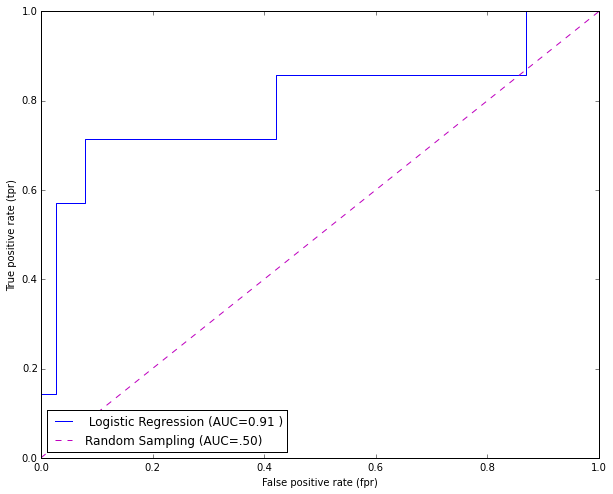

In [361]:
def prepareDataFrame():
    sentimentDF=pd.read_csv(dirLocation+'/'+'movie_sentiments',sep=',')
    sentimentDF.shape
    sentimentDF=movieCorpus.merge(sentimentDF,right_on='movieName',left_on='title')
    sentimentDF.columns
    # sentimentDF.dropna(inplace=True)
    sentimentDF['week_tweet_count_0']=sentimentDF['pos_week_0']+sentimentDF['neg_week_0']
    sentimentDF['week_tweet_count_1']=sentimentDF['pos_week_1']+sentimentDF['neg_week_1']
    sentimentDF['week_tweet_count_2']=sentimentDF['pos_week_2']+sentimentDF['neg_week_2']
    sentimentDF['week_tweet_count_3']=sentimentDF['pos_week_3']+sentimentDF['neg_week_3']
    sentimentDF['earning_per_theatre']=sentimentDF['Opening_Weekend']/sentimentDF['Theatres']
    sentimentDF['pt_nt_ratio_all_weeks']=((sentimentDF['pos_week_0']/(sentimentDF['neg_week_0']+1))+(sentimentDF['pos_week_1']/(sentimentDF['neg_week_1']+1))+(sentimentDF['pos_week_2']/(sentimentDF['neg_week_2']+1))+(sentimentDF['pos_week_3']/(sentimentDF['neg_week_3']+1)))*\
    (sentimentDF['week_tweet_count_0']+sentimentDF['week_tweet_count_1']+sentimentDF['week_tweet_count_2']+sentimentDF['week_tweet_count_3'])/4
    sentimentDF['Success']=np.where(sentimentDF['Opening_Weekend']>50000000, 1, 0)
    return sentimentDF

sentimentDF=prepareDataFrame()

def genreTokenizer(text):
    return text.split(',')

def doOpeningWeekendClassificationAndStoreCSV(plot_graph=True,store_csv=True):
    mapper = DataFrameMapper([ (['pt_nt_ratio_all_weeks'],None),
                              ('genres',CountVectorizer(binary=True, ngram_range=(1,1)))
                               
   ])
    X=mapper.fit_transform(sentimentDF)
   
#     X_columns=mapper.features[0][0] +mapper.features[1][1].get_feature_names()
#     X_columns
    Y=sentimentDF['Success']
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75,random_state=42)
#     decision_tree = DecisionTreeClassifier(max_depth=value,criterion="entropy")
    parametersToTune={'C':[1e-2,1e-3,1,1e1,1e2,1e3]}
    lr= LogisticRegression()
#     SVC(kernel='linear',max_iter=1000,probability=True)
    gs_lr = GridSearchCV(lr,parametersToTune,cv=5,score_func='roc_auc')
    gs_lr.fit(X_train,Y_train)
    accuracy_auc=str(round(np.mean(cross_validation.cross_val_score(gs_lr,X,Y,scoring="roc_auc")),2))
    accuracy=str(round(np.mean(cross_validation.cross_val_score(gs_lr,X,Y,scoring="accuracy")),2))
    print "Accuracy of the classifier is " , accuracy
    print "ROC Accuracy of the classifier is ", accuracy_auc
    print gs_lr.best_params_
    if store_csv:
        sentimentDF.to_csv(dirLocation+'/'+'sentiments_explore.csv')
   
    if plot_graph:
         Y_test_probability_lr=gs_lr.predict_proba(X_test)[:,1]
         fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(Y_test, Y_test_probability_lr)
         plotROCGraph(accuracy_auc,fpr_lr,tpr_lr,thresholds_lr,'Logistic Regression')
#     print X_columns        
#     print sentimentDF.describe()   
doOpeningWeekendClassificationAndStoreCSV()


In [114]:
element=sentimentDF['genres']

#to test the text classifier on an individual basis
data=[{"username":"Shondips","text":"I liked a @YouTube video Mission: Impossible Rogue Nation Trailer","date":1443994685000,"retweets":0,"favorites":0,"user_id":"1367684389","tweet_id":"650786995443208192"}]
processedTweet=preprocessTweets(data[0]['text'],'Mission:Impossible Rogue Nation')
print processedTweet
mapper = DataFrameMapper([
    (['budget'], None),
    ('genres',CountVectorizer(binary=True, ngram_range=(1,1)))
])
X=mapper.fit_transform(sentimentDF)
X_columns=mapper.features[0][0]+mapper.features[1][1].get_feature_names()
X_columns
# transformedGenres
# element1=json.loads(element[0])


liked


['budget',
 u'action',
 u'adventure',
 u'animation',
 u'comedy',
 u'crime',
 u'drama',
 u'family',
 u'fantasy',
 u'fiction',
 u'history',
 u'horror',
 u'music',
 u'mystery',
 u'romance',
 u'science',
 u'thriller',
 u'war',
 u'western']

## Conclusions 

We investigated whether tweets and their sentiments can add predictive power to predict the movie's opening box office weekend revenue, and found that they do add the predictive power. We believe these features can be used by production houses to determine the box office weekend revenue. Moreover, in the weeks prior to the movie's release, these features can be used to measure the marketing efficacy and marketing effort can then be channeled to improve the public sentiment or increase the awareness in public about the movie.   


# APPENDIX

The most relevant java source files are mentioned below. The complete source code is provided separately.





## MovieDB 

Main Class Of the package

```java

package edu.nyu.ds.moviedbgatherer.rest.service;

import edu.nyu.ds.moviedbgatherer.rest.pojo.DiscoverMovieResult;
import edu.nyu.ds.moviedbgatherer.rest.pojo.Movie;
import edu.nyu.ds.moviedbgatherer.rest.pojo.SearchedMovie;
import edu.nyu.ds.moviedbgatherer.rest.pojo.SearchedMovieResults;
import org.apache.commons.csv.CSVFormat;
import org.apache.commons.csv.CSVPrinter;
import org.apache.commons.csv.CSVRecord;
import org.slf4j.Logger;
import org.slf4j.LoggerFactory;
import rx.Observable;

import java.io.File;
import java.io.FileWriter;
import java.io.IOException;
import java.lang.reflect.Field;
import java.nio.file.FileSystem;
import java.util.*;
import java.util.concurrent.TimeUnit;

/**
 * Created by Ramandeep Singh on 04-11-2015.
 */
public class BuildMoviesDB {
    private static final MovieDBUtil movieUtil;
    private static final Logger logger= LoggerFactory.getLogger(BuildMoviesDB.class);
    private static final Scanner scanner;
    private static CSVPrinter csvPrinter=null;
    private static final CSVFormat csvFormat;
    static {
        movieUtil=new MovieDBUtil();
        scanner=new Scanner(System.in);
        csvFormat=CSVFormat.DEFAULT.withRecordSeparator("\r\n");
    }


    public static SearchedMovieResults handleSearchMovieByName(){
        String movieName = scanner.nextLine();
        logger.info("Searching for movie :{}", movieName);
        Map<String, String> requestMap = new HashMap<>();
        requestMap.put("query", movieName);
        SearchedMovieResults searchedMovieResults = movieUtil.searchMovies(requestMap);
        return searchedMovieResults;

    }
    public static DiscoverMovieResult handleDiscoverMovieResult(){
        Map<String, Object> requestMap = new HashMap<>();
        logger.info("Enter Year []: ");

        String yearValue = scanner.nextLine();
        if(yearValue!=null&&!yearValue.isEmpty()){
            requestMap.put("primary_release_year",Integer.parseInt(yearValue));
        }
        logger.info("Enter Vote Count threshold: this is the lower limit [0]:");
        String voteCountValue = scanner.nextLine();
        if(voteCountValue!=null&&!voteCountValue.isEmpty()){
            requestMap.put("vote_count.gte", Integer.parseInt(voteCountValue));
        }
        logger.info("Enter average rating threshold: lower limit [0]:");
        String lowRatingLimitValue= scanner.nextLine();
        if(lowRatingLimitValue!=null&&!lowRatingLimitValue.isEmpty()){
            requestMap.put("vote_average.gte", Integer.parseInt(lowRatingLimitValue));
        }

        logger.info("Enter average rating threshold: Higher limit [10]:");
        String highLimitValue=scanner.nextLine();
        if(highLimitValue!=null&&!highLimitValue.isEmpty()){
            requestMap.put("vote_average.lte", Integer.parseInt(highLimitValue));
        }
        logger.info("Enter pages to retrieve: 20 movies per page[5]:");
        String pageSize=scanner.nextLine();
        int pageSizeValue=5;
        if(pageSize!=null&&!pageSize.isEmpty()){
            pageSizeValue=Integer.parseInt(pageSize);
        }


//                logger.info("Enter Keywords separate them by comma (,):[]:");
//                String keywords=scanner.nextLine();
//                if(keywords!=null&&!keywords.isEmpty()){
//                    requestMap.put("keywords", keywords);
//                }
           DiscoverMovieResult discoverMovieResult=new DiscoverMovieResult();
           discoverMovieResult.initDiscoverMovieResult();
           for(int i=1;i<=pageSizeValue;i++){
               requestMap.put("page",i);
               DiscoverMovieResult  tempDiscoverMovieResult = movieUtil.discoverMovies(requestMap);
               discoverMovieResult.getResults().addAll(tempDiscoverMovieResult.getResults());
           }
           return discoverMovieResult;

    }

  /**
     * This method does rate limited fetch of MovieDB API
     * It uses RXJava for achieving rate limiting
     * @param searchedMovies
     * @param saveFile
     * @param file
     * @return
     */
    public static List<Movie> invokeRateLimitedFetch(List<SearchedMovie> searchedMovies,boolean saveFile, File file){
        List<Movie> movies=new ArrayList<>();

           Observable.zip(Observable.from(searchedMovies),
                   Observable.interval(2, TimeUnit.SECONDS), (obs,timer)->obs)
                   .doOnNext(item -> {
                       Movie movie = movieUtil.getMovieDetails(item.getId());
                       movies.add(movie);
                       if(saveFile) {
                           writeRecordToFile(file, movie);
                       }
                   }




    ).toList().toBlocking().first();
     if(csvPrinter!=null){
         try {
             csvPrinter.close();
         } catch (IOException e) {

         }
     }
        return movies;
    }
    private static void writeRecordToFile(File file , Movie movie) {
        try {
            if (csvPrinter == null) {
                csvPrinter = new CSVPrinter(new FileWriter(file), csvFormat);
                printHeaderRecord(csvPrinter);

            }
            printValueRecord(csvPrinter, movie);
        }
        catch (IOException e) {
            logger.error("Unable to create csv printer or write record {}", movie, e);
            return;
        }



    }

    private static void printValueRecord(CSVPrinter csvPrinter, Movie movie) throws IOException{
        Field[] fields= Movie.class.getDeclaredFields();
        Object[] fieldValues=new String[fields.length];
        for(int i=0;i<fields.length;i++){
            try {
                fields[i].setAccessible(true);
                fieldValues[i]=fields[i].get(movie).toString();
                fields[i].setAccessible(false);
            } catch (IllegalAccessException e) {
                e.printStackTrace();
            }


        }
        csvPrinter.printRecord(fieldValues);
    }

    private static void printHeaderRecord(CSVPrinter csvPrinter) throws IOException {
       Field[] fields= Movie.class.getDeclaredFields();
       String[] fieldNames=new String[fields.length];
       for(int i=0;i<fields.length;i++){
           fieldNames[i]=fields[i].getName();
       }
      csvPrinter.printRecord(fieldNames);
    }

    public static void main(String args[]){
        logger.info("Choose the option: \n" +
                "1.Search Movie By Name \n"+
                "2.Discover Movie By Criterion \n"+
                "3.Get Movie Detail \n"+
                "4.Discover and get Movie Detail");

        Scanner scanner=new Scanner(System.in);
        int option=Integer.parseInt(scanner.nextLine());
        switch (option){
            case 1: {
                logger.info("You chose option 1: \n Now Enter the movie name");
                SearchedMovieResults searchedMovieResults=handleSearchMovieByName();
                if (searchedMovieResults != null) {
                    List<SearchedMovie> movies = searchedMovieResults.getResults();
                    if (movies != null) {
                        for (SearchedMovie movie : movies) {
                            logger.info("Got result {}", movie);
                        }
                    }
                }
                break;
            }
            case 2: {
                logger.info("You chose option 2:");
                DiscoverMovieResult discoverMovieResult=handleDiscoverMovieResult();
                if (discoverMovieResult != null) {
                    List<SearchedMovie> movies = discoverMovieResult.getResults();
                    if (movies != null) {
                        for (SearchedMovie movie : movies) {
                            logger.info("Got result {}", movie);
                        }
                    }
                }
                break;
            }
            case 3:{
                logger.info("You chose option 3:");
                logger.info("Now Enter the movie Id:");
                String movieIdValue= scanner.nextLine();
                if(movieIdValue!=null){
                   Movie movie= movieUtil.getMovieDetails(Long.parseLong(movieIdValue));
                   logger.info("Got Movie {}",movie);
                }
                break;
            }
            case 4:{
                logger.info("You chose option 4:");
                logger.info("Would You like to save the csv file [Y/N] [Y]?");
                String saveFile=scanner.nextLine();
                File file=null;
                boolean shouldFileBeSaved=false;
                if(saveFile!=null&&saveFile.equalsIgnoreCase("Y")){
                    shouldFileBeSaved=true;
                    logger.info("Enter the complete file name including path [.//movie_corpus.csv]?");

                    String fileLocation=scanner.nextLine();
                    if(fileLocation==null||fileLocation.isEmpty()){
                        file =new File(".\\movie_corpus.csv");
                    }
                    else{
                        file=new File(fileLocation);
                    }

                }
                DiscoverMovieResult discoverMovieResult=handleDiscoverMovieResult();
                if(discoverMovieResult!=null){
                  List<Movie> movies=  invokeRateLimitedFetch(discoverMovieResult.getResults(),shouldFileBeSaved,file);
                    for(Movie movie:movies){
                      logger.info("Got Movie : {}",movie);
                  }
                }

            }

        }

    }

}
```

Service Interface
``` java
package edu.nyu.ds.moviedbgatherer.rest.interfaces;

import edu.nyu.ds.moviedbgatherer.rest.pojo.DiscoverMovieResult;
import edu.nyu.ds.moviedbgatherer.rest.pojo.Movie;
import edu.nyu.ds.moviedbgatherer.rest.pojo.SearchedMovieResults;
import retrofit.http.GET;
import retrofit.http.Path;
import retrofit.http.QueryMap;

import java.util.Map;

/**
 * Created by Ramandeep Singh on 04-11-2015.
 */
public interface MovieDBService {
    @GET("/discover/movie")
    public DiscoverMovieResult discoverMovies(@QueryMap Map requestParams);

    @GET("/search/movie")
    public SearchedMovieResults searchMovies(@QueryMap Map requestParams);

    @GET("/movie/{id}")
    public Movie getMovieDetails(@Path("id") long id,@QueryMap Map requestParams);


}
```

Utility For invoking the service

```java 

package edu.nyu.ds.moviedbgatherer.rest.service;

import edu.nyu.ds.moviedbgatherer.rest.pojo.DiscoverMovieResult;
import edu.nyu.ds.moviedbgatherer.rest.pojo.Movie;
import edu.nyu.ds.moviedbgatherer.rest.pojo.SearchedMovieResults;
import edu.nyu.ds.moviedbgatherer.rest.interfaces.MovieDBService;
import retrofit.RestAdapter;

import java.util.HashMap;
import java.util.Map;
import java.util.ResourceBundle;

/**
 * Created by Ramandeep Singh on 04-11-2015.
 */
public class MovieDBUtil {
    private static final ResourceBundle rb;
    private static final String api_key;
    private static final String endPoint;
    private static final RestAdapter restAdapter;
    private static final MovieDBService movieDBService;
    static {
        rb=ResourceBundle.getBundle("app");
        api_key=rb.getString("api_key");
        endPoint=rb.getString("service_endpoint_moviedb");
        String logLevel=rb.getString("log_level_retrofit");
        restAdapter=new RestAdapter.Builder().setEndpoint(endPoint).setLogLevel(RestAdapter.LogLevel.valueOf(logLevel)).build();
        movieDBService =restAdapter.create(MovieDBService.class);
    }
    public DiscoverMovieResult discoverMovies(Map requestMap){
        requestMap.put("api_key",api_key);
       return movieDBService.discoverMovies(requestMap);

    }
    public SearchedMovieResults searchMovies(Map requestMap){
        requestMap.put("api_key",api_key);
        return movieDBService.searchMovies(requestMap);

    }
    public Movie getMovieDetails(long movieId){
        Map requestMap=new HashMap<>();
        requestMap.put("api_key",api_key);
        return movieDBService.getMovieDetails(movieId,requestMap);

    }




}
```



## Twitter Service

This is the REST service class in java that the python program invokes, it invokes an internal library to search and fetch the historic data

```java 

package com.blogspot.ramannanda.data.twitter.rest.service;

import me.jhenrique.manager.TweetManager;
import me.jhenrique.manager.TwitterCriteria;
import me.jhenrique.model.Tweet;

import javax.ws.rs.GET;
import javax.ws.rs.Path;
import javax.ws.rs.Produces;
import javax.ws.rs.core.Context;
import javax.ws.rs.core.MediaType;
import javax.ws.rs.core.MultivaluedMap;
import javax.ws.rs.core.UriInfo;
import java.util.List;
import java.util.Map;

/**
 * Created by Ramandeep Singh on 05-11-2015.
 */
@Path(("/search/"))
public class TwitterSearchService {
@GET
@Produces(MediaType.APPLICATION_JSON+"; charset=UTF-8")
   public List<Tweet> searchTwitter(@Context UriInfo ui)
{
   MultivaluedMap requestMap=ui.getQueryParameters();
   String query=(String)requestMap.getFirst("q");
   String maxResults= (String)requestMap.getFirst("max");
   String lang=(String)requestMap.getFirst("lang");
   int maxResultsValue=100;
   if(maxResults!=null&&!maxResults.isEmpty()){
     maxResultsValue=Integer.parseInt(maxResults);
   }
    if(maxResultsValue <=0){
    maxResultsValue=100;
    }

   String userName=(String) requestMap.getFirst("u");
   String since=(String) requestMap.getFirst("since");
   String until=(String) requestMap.getFirst("until");
   String to=(String) requestMap.getFirst("to");
   String distance=(String) requestMap.getFirst("distance");
   int distanceValue=0;
   if(distance!=null){
       distanceValue=Integer.parseInt(distance);
   }
   String near=(String) requestMap.getFirst("near");

   boolean toValue=false;
   if(to!=null&&to.equalsIgnoreCase("1")){
      toValue=true;
   }
   TwitterCriteria criteria = TwitterCriteria.create()
           .setUsername(userName)
           .setSince(since)
           .setQuerySearch(query)
           .setUntil(until)
           .setTo(toValue)
           .setDistance(distanceValue).setLocation(near)
           .setMaxTweets(maxResultsValue).setLang(lang);
   return TweetManager.getTweets(criteria);
}

}
```